<a href="https://colab.research.google.com/github/2kunal6/UniBonn/blob/master/cuda_lab/2/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
datasets loaded
Label: tensor(4)


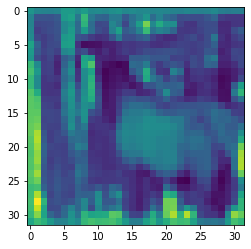

Running on the GPU
epoch: 0, loss: 2.188253879547119
epoch: 1, loss: 2.268139600753784
epoch: 2, loss: 2.3882336616516113
epoch: 3, loss: 2.4244961738586426
epoch: 4, loss: 2.3327198028564453
epoch: 5, loss: 3.2951321601867676
epoch: 6, loss: 2.598301410675049
epoch: 7, loss: 2.0993573665618896
epoch: 8, loss: 2.2327263355255127
epoch: 9, loss: 2.9034056663513184
Accuracy of the network on the 10000 test images: 21 %


In [9]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)

transform_list = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
            #transforms.Normalize([0.5,],[0.5,])
        ])
train = torch.utils.data.DataLoader(
    datasets.CIFAR10("./sample_data", train=True, transform=transform_list, download=True), batch_size = 32, shuffle = True
)

test = torch.utils.data.DataLoader(
    datasets.CIFAR10("./sample_data", train=False, transform=transform_list, download=True), batch_size = 32, shuffle = True
)

print("datasets loaded")

IMG_SIZE = 32*32

for data in train:
  X, y = data[0], data[1]
  plt.imshow(X[0].reshape(32, 32))
  print("Label: " + str(y[0]))
  plt.show()
  break

class LogisticRegression(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
    return self.linear(x)

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

model = LogisticRegression(IMG_SIZE, 10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
  for data in train:
    X, y = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    output = model(X.view(-1, IMG_SIZE))
    loss = F.cross_entropy(output, y)
    loss.backward()
    optimizer.step()
  print(f'epoch: {epoch}, loss: {loss}')

total = 0
correct = 0

with torch.no_grad():
  for data in test:
    X, y = data[0].to(device), data[1].to(device)
    output = model(X.view(-1, IMG_SIZE))
    _, predicted = torch.max(output, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))